### Building MICXEDLinear MOdelTo predict Emails Open Rates (OR%) , Based on the following Features 
- Time ( month of the year , day of the week )
- Pirority of email , main or reminder 
- Category ( interval , final )
- Constructed Features
 - Length of the subject 
 - Personalization of Email
 - Having emoji or not
 - Casual tone or formal 
 - Urgency at the subject 
 - Metion of price or discount in the subject 
 - Imperative tone in the subject 
 - Mention of product in the subject


In [1]:
#importing libraries 
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
#r reading the data as a dataframe
df = pd.read_csv("Model_Data.csv")
df.columns = df.columns.str.strip()

In [3]:
columns_to_drop = [ "translation", "CTR clean %","Month"]  
df = df.drop(columns=columns_to_drop, errors='ignore')

In [4]:
# Convert to datetime
df['Sent_Date'] = pd.to_datetime(df['Sent_Date'], errors='coerce')

# Create a Month column (numeric)
df['Month'] = df['Sent_Date'].dt.month

In [5]:
# List the columns  to replace 1/0
cols_to_replace = ['Personalization',"Emoji",'Urgency',"Tone",'Price_or_Discount','Imperative_Tone','Product']
  

# Replace 1 → 'yes' and 0 → 'no' in those columns
df[cols_to_replace] = df[cols_to_replace].replace({1: 'yes', 0: 'no'})
df["Length_Of_subject"]=df["Length_Of_subject"].replace({1: "long", 0:"short"})
month_map = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

# Replace numeric month values with names
df["Month"] = df["Month"].map(month_map)





In [6]:
categorical_columns = [
    'Day_of_week',
    'Category_name',
    'Main_Vs_REM',
    'Personalization',
    'Emoji',
    'Urgency',
    'Tone',
    'Price_or_Discount',
    'Imperative_Tone',
    'Product',
    'Length_Of_subject',
    'Month',
    "Subject"
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

In [7]:
df = df.sort_values("Sent_Date").reset_index(drop=True)

In [8]:

# finding outliers 
def get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3):
    """
    Detect outliers in each specified numeric column using Z-score.
    
    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to check
    - threshold: Z-score cutoff (default 3)
    
    Returns:
    - Dictionary: column name -> DataFrame of outlier rows
    """
    outlier_dict = {}
    
    for col in columns:
        if col in df.columns:
            col_data = df[col]
            z_scores = np.abs(stats.zscore(col_data.dropna()))
            col_outliers = df.loc[col_data.dropna().index[z_scores > threshold]]
            outlier_dict[col] = col_outliers
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
            outlier_dict[col] = pd.DataFrame()  # empty DataFrame if column not found
    
    return outlier_dict

# Example usage
outliers = get_column_outliers(df, columns=['Sendings', 'OR'], threshold=3)



In [9]:

lower_pct = 0.01  # 1st percentile
upper_pct = 0.99  # 99th percentile

# List of columns to Winsorize
columns_to_winsorize = ['Sendings', 'OR']

for col in columns_to_winsorize:
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    df[col] = np.clip(df[col], lower, upper)  # Cap values at thresholds
    print(f"{col}: capped below {lower:.3f}, capped above {upper:.3f}")



Sendings: capped below 357.000, capped above 241306.620
OR: capped below 0.057, capped above 0.229


In [10]:
# creating the formula for mixed linear model 
formula = (
    "OR ~ C(Day_of_week) + C(Category_name) + C(Main_Vs_REM) + "
    "C(Personalization) + C(Emoji) + C(Urgency) + C(Tone) + "
    "C(Price_or_Discount) + C(Imperative_Tone) + C(Product) + "
    "C(Length_Of_subject) + C(Month) + Letter_Count + Sendings  "
)

In [11]:
# spiliting data 
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 1023, Test size: 256


In [12]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    formula=formula,
    data=train_df,
    groups=train_df["Subject"]
    
)
result = model.fit()
print(result.summary())

c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       OR       
No. Observations:         1023          Method:                   REML     
No. Groups:               37            Scale:                    0.0007   
Min. group size:          1             Log-Likelihood:           2137.3809
Max. group size:          72            Converged:                No       
Mean group size:          27.6                                             
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.193    0.018  10.775 0.000  0.158  0.228
C(Day_of_week)[T.Monday]        -0.003    0.010  -0.326 0.744 -0.022  0.016
C(Day_of_week)[T.Saturday]      -0.011    0.007  -1.695 0.090 -0.025  0.002
C(Day_of_week)[T.Sunday]       

c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 5.981161
  warnings.warn(msg, ConvergenceWarning)
c:\Users\TOWER-PC\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


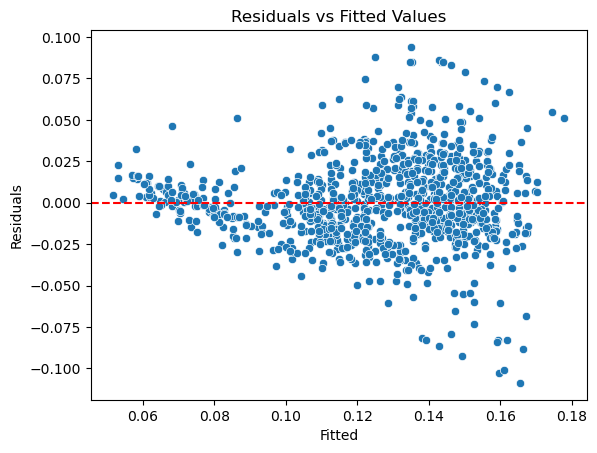

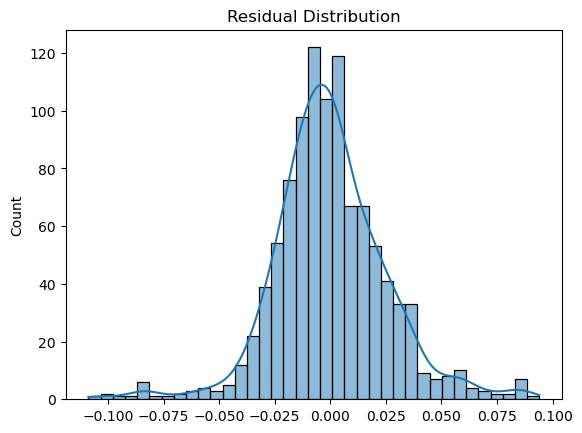

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
resid = result.resid
fitted = result.fittedvalues

# Plot residuals vs fitted
sns.scatterplot(x=fitted, y=resid)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted")
plt.ylabel("Residuals")
plt.show()

# Residual distribution
sns.histplot(resid, kde=True)
plt.title("Residual Distribution")
plt.show()


In [14]:
#  Generate predictions on both train and test sets
train_df["predicted"] = result.predict(train_df)
test_df["predicted"]  = result.predict(test_df)

# Evaluate model performance
def evaluate_performance(true, pred, label=""):
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2   = r2_score(true, pred)
    print(f"{label} RMSE: {rmse:.4f}, R²: {r2:.3f}")
    return rmse, r2

evaluate_performance(train_df["OR"], train_df["predicted"], "Train")
evaluate_performance(test_df["OR"],  test_df["predicted"],  "Test")

Train RMSE: 0.0262, R²: 0.477
Test RMSE: 0.0284, R²: 0.409


(0.0284163232338072, 0.4087392594416457)

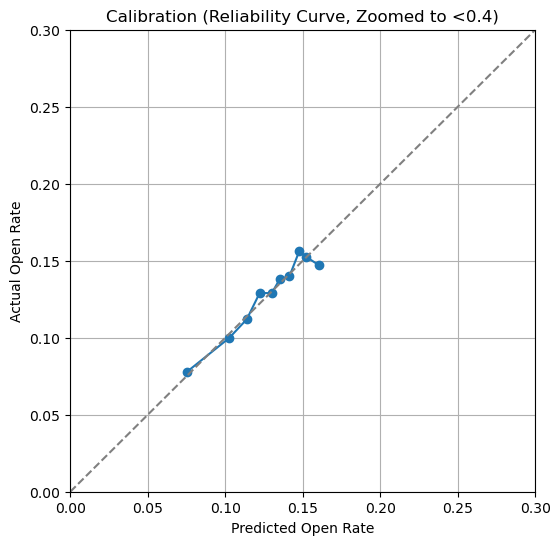

,decile,mean_pred,weighted_actual,count
0,0,0.075082,0.077710,26
1,1,0.102494,0.099819,26
2,2,0.113880,0.111980,25
3,3,0.122227,0.129116,26
4,4,0.129976,0.128900,25
5,5,0.135201,0.138165,26
6,6,0.141366,0.139836,25
7,7,0.147676,0.156065,26
8,8,0.152158,0.152588,25
9,9,0.160405,0.147064,26


In [15]:
# Create calibration table (by deciles)

# Predicted vs actual
test_df["predicted_OR"] = result.predict(test_df)
test_df["actual_OR"] = test_df["OR"]

# Create calibration table (by deciles)
test_df["decile"] = pd.qcut(test_df["predicted_OR"], 10, labels=False)
calibration_table = test_df.groupby("decile").agg(
    mean_pred=("predicted_OR", "mean"),
    weighted_actual=("actual_OR", "mean"),
    count=("OR", "size")
).reset_index()

# Plot calibration (adjusted scale)
plt.figure(figsize=(6, 6))
plt.plot(calibration_table["mean_pred"], calibration_table["weighted_actual"], marker="o")
plt.plot([0, 0.4], [0, 0.4], linestyle="--", color="gray")  # scale limited to 0.4
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.xlabel("Predicted Open Rate")
plt.ylabel("Actual Open Rate")
plt.title("Calibration (Reliability Curve, Zoomed to <0.4)")
plt.grid(True)
plt.show()

calibration_table


In [16]:
# Sort by predicted open rate
sorted_df = test_df.sort_values("predicted_OR", ascending=False)

# Compute top decile
top_decile_cutoff = int(len(sorted_df) * 0.1)
top_decile = sorted_df.head(top_decile_cutoff)

overall_avg_or = sorted_df["actual_OR"].mean()
top_decile_avg_or = top_decile["actual_OR"].mean()
lift = top_decile_avg_or / overall_avg_or

print(f"Overall Avg OR: {overall_avg_or:.4f}")
print(f"Top 10% Avg OR: {top_decile_avg_or:.4f}")
print(f"Lift: {lift:.2f}×")


Overall Avg OR: 0.1280
Top 10% Avg OR: 0.1458
Lift: 1.14×


In [17]:
# evaluation metrics ......

# Predictions
train_pred = result.predict(train_df)
test_pred = result.predict(test_df)

# True values
y_train = train_df["OR"]
y_test = test_df["OR"]

# Compute metrics
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0,1]
    bias = np.mean(y_pred - y_true)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # avoid division by zero
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - len(result.fe_params) - 1)
    return {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape,
        "R²": r2,
        "Adj R²": adj_r2,
        "Corr": corr,
        "Bias": bias
    }

train_metrics = regression_metrics(y_train, train_pred)
test_metrics = regression_metrics(y_test, test_pred)

print("Train metrics:")
for k, v in train_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nTest metrics:")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

Train metrics:
RMSE: 0.0262
MAE: 0.0194
MAPE (%): 16.4637
R²: 0.4772
Adj R²: 0.4614
Corr: 0.6913
Bias: -0.0007

Test metrics:
RMSE: 0.0284
MAE: 0.0214
MAPE (%): 18.0763
R²: 0.4087
Adj R²: 0.3299
Corr: 0.6401
Bias: -0.0001


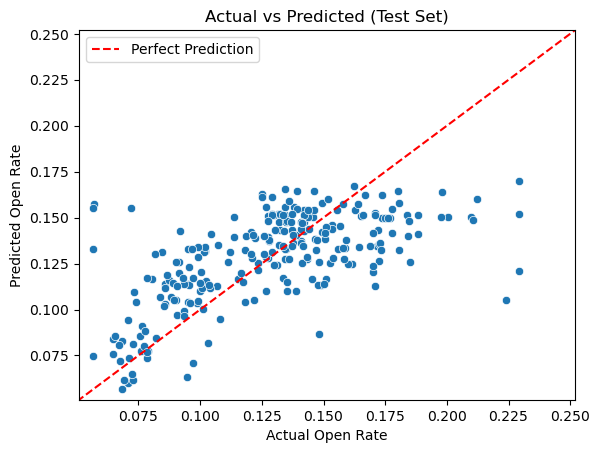

In [18]:

sns.scatterplot(x=y_test, y=test_pred)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')

# Dynamically set axis limits based on data
min_val = min(y_test.min(), test_pred.min()) * 0.9
max_val = max(y_test.max(), test_pred.max()) * 1.1
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.xlabel("Actual Open Rate")
plt.ylabel("Predicted Open Rate")
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.show()


## Creating Prediction function and prediction app

In [19]:

import pandas as pd

def predict_open_rate(model, input_data, train_df):
    """
    Predict email open rate using the fitted mixed linear model.
    
    Parameters:
    - model: fitted mixed linear model (e.g., 'result')
    - input_data: dict or DataFrame containing feature values
    - train_df: training DataFrame (for category consistency)
    
    Returns:
    - Predicted open rate (float)
    """
    
    # Convert input to DataFrame if dictionary provided
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()
    
    # Ensure categorical types match training data
    categorical_cols = [
        'Day_of_week', 'Category_name', 'Main_Vs_REM', 'Personalization',
        'Emoji', 'Urgency', 'Tone', 'Price_or_Discount', 'Imperative_Tone',
        'Product', 'Length_Of_subject', 'Month', 'Subject'
    ]
    
    for col in categorical_cols:
        if col in train_df.columns:
            input_df[col] = input_df[col].astype(
                pd.CategoricalDtype(categories=train_df[col].cat.categories)
            )
    
    # Predict
    predicted_or = model.predict(input_df)[0]
    predicted_or_pct = predicted_or * 100
    
    print(f"Predicted Open Rate: {predicted_or_pct:.2f}%")
    return predicted_or

# === Example input (aligned with training categories) ===
example_input = {
    'Day_of_week': 'Monday',
    'Category_name': 'NL Interval',
    'Main_Vs_REM': 'MAIN',
    'Personalization': 'yes',
    'Emoji': 'no',
    'Urgency': 'no',
    'Tone': 'yes',                
    'Price_or_Discount': 'no',
    'Imperative_Tone': 'no',
    'Product': 'yes',            
    'Length_Of_subject': 'short',
    'Month': 'January',
    'Subject': 'Weekly Update: New Features Inside',
    'Letter_Count': 42,
    'Sendings': 10000
}

# === Generate prediction ===
predicted_or = predict_open_rate(result, example_input, train_df)


Predicted Open Rate: 16.39%


In [20]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# === Interactive Prediction Widget ===
def interactive_predictor(model, train_df):

    # Dropdown options from your confirmed categories
    options = {
        'Day_of_week': ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
        'Category_name': ['NL Final', 'NL Interval'],
        'Main_Vs_REM': ['MAIN', 'REM'],
        'Personalization': ['no', 'yes'],
        'Emoji': ['no', 'yes'],
        'Urgency': ['no', 'yes'],
        'Tone': ['no', 'yes'],
        'Price_or_Discount': ['no', 'yes'],
        'Imperative_Tone': ['no', 'yes'],
        'Product': ['no', 'yes'],
        'Length_Of_subject': ['long', 'short'],
        'Month': ['April', 'August', 'December', 'February', 'January', 'July', 'June', 
                  'March', 'May', 'November', 'October', 'September']
    }

    # Create widgets
    widgets_dict = {
        col: widgets.Dropdown(options=opts, description=col)
        for col, opts in options.items()
    }

    subject_widget = widgets.Text(value='Weekly Update: New Features Inside', description='Subject')
    letter_count_widget = widgets.IntText(value=42, description='Letter_Count')
    sendings_widget = widgets.IntText(value=10000, description='Sendings')

    # Output area
    output = widgets.Output()

    # Prediction function
    def on_predict_button_clicked(b):
        with output:
            clear_output()

            # Collect input
            input_data = {col: w.value for col, w in widgets_dict.items()}
            input_data['Subject'] = subject_widget.value
            input_data['Letter_Count'] = letter_count_widget.value
            input_data['Sendings'] = sendings_widget.value

            # Convert to DataFrame
            input_df = pd.DataFrame([input_data])
            for col in options.keys():
                input_df[col] = input_df[col].astype(
                    pd.CategoricalDtype(categories=train_df[col].cat.categories)
                )

            # Predict
            predicted_or = model.predict(input_df)[0]
            print(f"📈 Predicted Open Rate: {predicted_or*100:.2f}%")

    # Predict button
    predict_button = widgets.Button(description="Predict Open Rate", button_style='success')
    predict_button.on_click(on_predict_button_clicked)

    # Display
    form_items = list(widgets_dict.values()) + [
        subject_widget, letter_count_widget, sendings_widget, predict_button, output
    ]
    display(widgets.VBox(form_items))


In [21]:
interactive_predictor(result, train_df)